# Departamento médico

## Importação das bibliotecas e base de dados

In [ ]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xray_directory = '/content/drive/MyDrive/Departamento médico/Dataset'

In [ ]:
os.listdir(xray_directory)

['.DS_Store', '0', '1', '2', '3']

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
133 * 4

532

In [ ]:
532 / 40

13.3

In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

In [ ]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

## Visualização dos dados

In [ ]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
np.argmax(train_labels[0])

2

In [ ]:
labels_names[1]

'Normal'

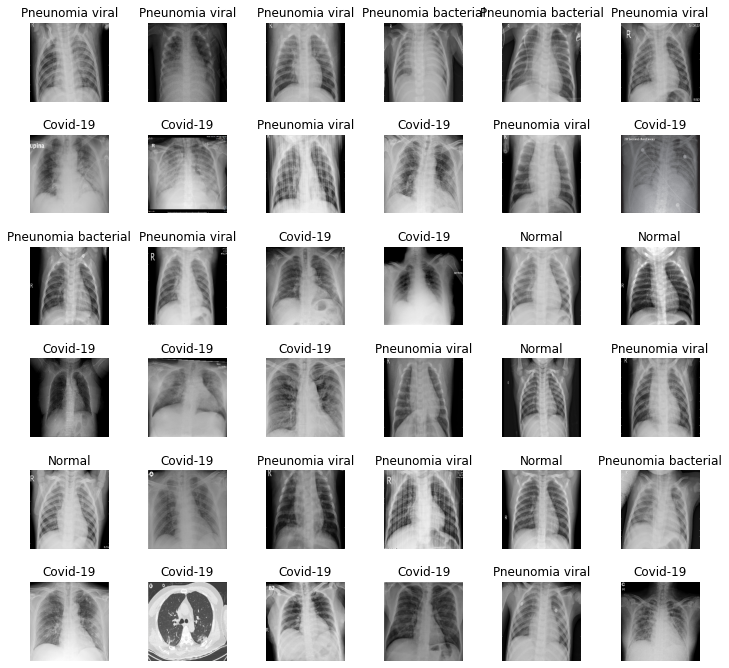

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Carregamento da rede neural com pesos pré-treinados

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
len(base_model.layers)

175

In [ ]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

## Construção e treinamento do modelo de deep learning

In [ ]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

<ipython-input-32-57e0cc005262>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs = 25,


Epoch 1/25
133/133 [==============================] - 89s 511ms/step - loss: 1.0798 - accuracy: 0.6955
Epoch 2/25
133/133 [==============================] - 17s 122ms/step - loss: 0.5243 - accuracy: 0.8835
Epoch 3/25
133/133 [==============================] - 16s 122ms/step - loss: 0.4576 - accuracy: 0.9117
Epoch 4/25
133/133 [==============================] - 18s 128ms/step - loss: 0.2956 - accuracy: 0.9398
Epoch 5/25
133/133 [==============================] - 16s 122ms/step - loss: 0.2731 - accuracy: 0.9342
Epoch 6/25
133/133 [==============================] - 17s 128ms/step - loss: 0.1443 - accuracy: 0.9662
Epoch 7/25
133/133 [==============================] - 17s 127ms/step - loss: 0.1120 - accuracy: 0.9718
Epoch 8/25
133/133 [==============================] - 17s 129ms/step - loss: 0.2485 - accuracy: 0.9756
Epoch 9/25
133/133 [==============================] - 17s 125ms/step - loss: 0.1592 - accuracy: 0.9737
Epoch 10/25
133/133 [==============================] - 17s 129ms/step - l

## Avaliação da rede neural

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

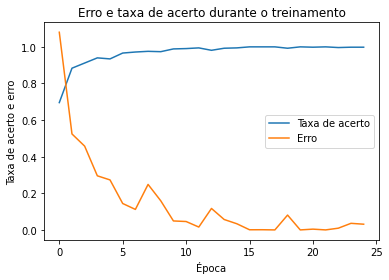

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [ ]:
test_directory = '/content/drive/MyDrive/Departamento médico/Test/'

In [ ]:
os.listdir(test_directory)

['3', '2', '1', '0']

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator)

<ipython-input-41-fff1a6b05c9b>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator)


In [ ]:
evaluate

[2.7036190032958984, 0.75]

In [ ]:
len(os.listdir(test_directory))

4

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 27ms/step


In [ ]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 1, 0, 2, 1, 3, 3, 3, 3, 3, 3]


In [ ]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(original, prediction)

0.775

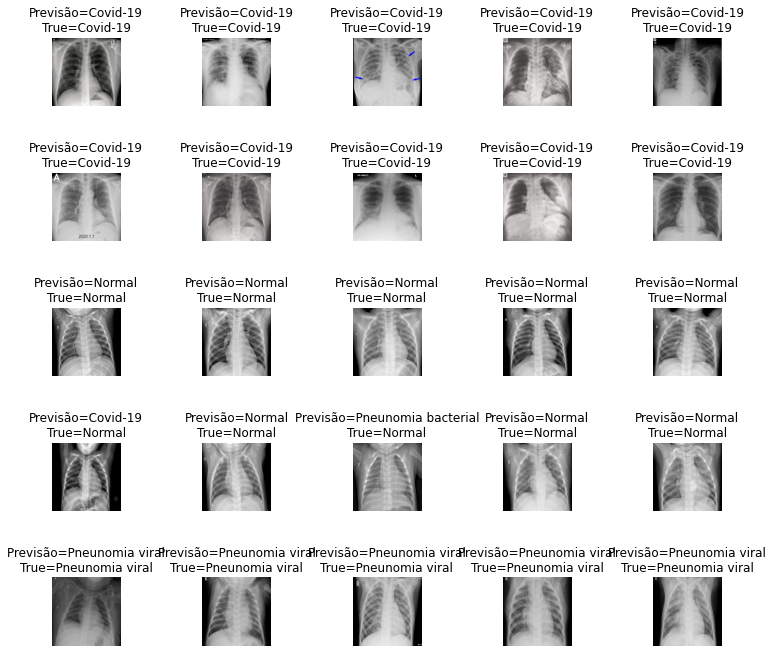

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [ ]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

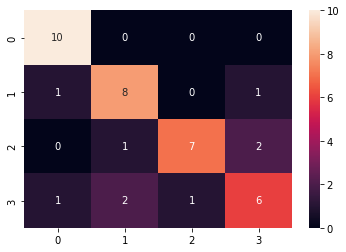

In [ ]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.73      0.80      0.76        10
           2       0.88      0.70      0.78        10
           3       0.67      0.60      0.63        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



## Classificação de somente uma imagem

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [ ]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
4 * 4 * 2048

32768

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Departamento médico/Test/0/radiol.2020200490.fig3.jpeg')

In [ ]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

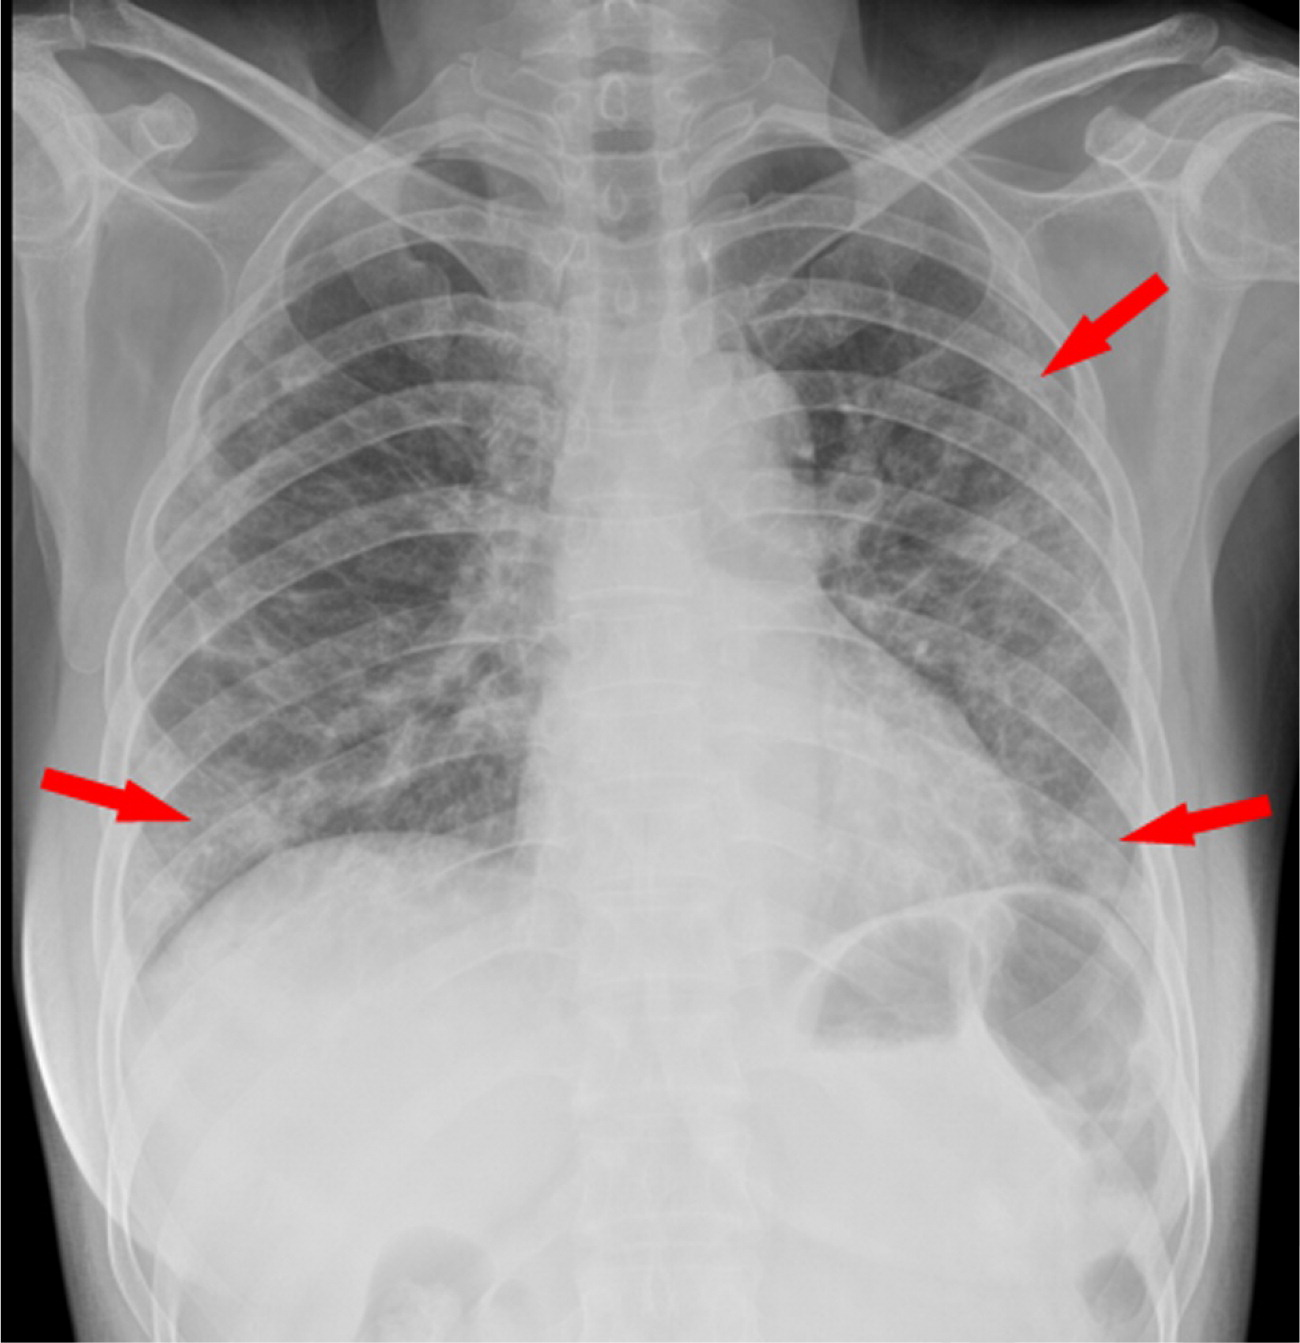

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

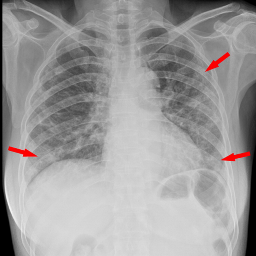

In [ ]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [ ]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [ ]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 0., 0., 0.]], dtype=float32)>

In [ ]:
predict2 = np.argmax(predict)
predict2

0

In [ ]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)